We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# Overview

In the following notebook we compute the Poincaré Map of the three-dimensional, steady ABC-flow. The notebook is structured as follows:

1. Define analytic velocity field of the three-dimensional solution of the Euler equations, the steady and spatially periodic Arnold-Beltrami-Childress (ABC) flow:
\begin{equation}
\begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \\ \dot{z}(t) \end{pmatrix} = \begin{pmatrix} u \\ v \\ w \end{pmatrix} = \begin{pmatrix} \sqrt{3}\sin(z)+\cos(y) \\ \sqrt{2}\sin(x) + \sqrt{3}\cos(z) \\ \sin(y)+\sqrt{2}\cos(x) \end{pmatrix}, \quad (x,y,z) \in [0, 2\pi]^3 \label{eq: periodicABC} \tag{1}
\end{equation}
2. Define computational parameters.
3. Define spatio-temporal domain.
4. Poincare map:

    All 2D structurally stable invariant manifolds of the 3D direction field:
    
    \begin{equation}
    \mathbf{x}_0'(s) = \mathbf{\xi}_2(\mathbf{x}_0(s);t_0,t_N) \label{eq: relaxedLCS} \tag{2}
    \end{equation}
    
    are relaxed LCS. All relaxed attracting LCSs, repelling LCSs and elliptic LCSs can be sought as invariant manifolds of the same direction field \ref{eq: relaxedLCS}, defined by the right intermediate singularvector field of the gradient of the flow map.
    
    Compute tensorlines over the dummy time-interval [0, 2*$10^4$] generated from $ \mathbf{\xi}_2 $, where $ \mathbf{\xi}_2 $ is the intermediate right singularvector-field of $ \mathbf{\nabla F}(\mathbf{x},t) $. The tensorlines are launched from the Poincare section given by the z=0 plane. In order to have precise results, $ \mathbf{\nabla F}(\mathbf{x},t) $ is evaluated at every dummy time-step of the tensorline integration. Hence, the computational time of this demo is more than 4 days on a 2.3 GHz 18-Core Intel Xeon W processor.
    
    Compute Poincare map by sampling tensorline trajectories which intersect the Poincare section z = 0.

6. References   

# Analytic velocity field

Here we define the analytic velocity field of a steady ABC-flow. The parameters are chosen as in [1,2].

In [2]:
# import numpy
import numpy as np

# import math tools
from math import sqrt, pi

def velocity(x, y, z):

    u = sqrt(3)*np.sin(z)+np.cos(y)
    v = sqrt(2)*np.sin(x)+sqrt(3)*np.cos(z)
    w = np.sin(y)+sqrt(2)*np.cos(x)
    
    return np.array([u, v, w])

def dudx(x, y, z):
    return 0*x.copy()
def dudy(x, y, z):
    return -np.sin(y)
def dudz(x, y, z):
    return sqrt(3)*np.cos(z)

def dvdx(x, y, z):
    return sqrt(2)*np.cos(x)
def dvdy(x, y, z):
    return 0*x.copy()
def dvdz(x, y, z):
    return -sqrt(3)*np.sin(z)

def dwdx(x, y, z):
    return -sqrt(2)*np.sin(x)
def dwdy(x, y, z):
    return np.cos(y)
def dwdz(x, y, z):
    return 0*x.copy()

# Computational parameters

Here we define the computational parameters and the analytic velocity field.

In [3]:
# number of cores to be used for parallel computing
Ncores = 16

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 10 # float

# Time step-size
dt = 0.05 # float

# dummy time interval
ds = 0.05
s_dummy = np.arange(0, 5*10**4, ds)

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Poincare Map

In [5]:
# function to compute gradient of flow map along particle trajectories.
def integration_dDF_dt(time, x):
    
    # reshape x
    x = x.reshape(3, -1)
    
    # Initialize arrays for flow map and derivative of flow map
    Fmap = np.zeros((3, x.shape[1]))
    DF = np.zeros((3, 3, x.shape[1]))
    
    # Step-size
    dt = time[1]-time[0]

    # initial conditions
    Fmap = x
    DF[0,0,:] = 1
    DF[1,1,:] = 1
    DF[2,2,:] = 1
    
    # Runge Kutta 4th order integration with fixed step size dt
    for t in time[:-1]:
        
        #if t % 0.1 == 0:
        #    print("Percentage completed: ", 100*np.around(t/time[-1], 2))
        
        Fmap, _, DF = RK4_step(t, Fmap, DF, dt)
    
    return DF

# function to compute gradient of the velocity
def grad_velocity(x, y, z):
    
    grad_vel = np.zeros((x.shape[0], 3, 3))
    
    grad_vel[:,0,0] = dudx(x, y, z)
    grad_vel[:,1,0] = dvdx(x, y, z)
    grad_vel[:,2,0] = dwdx(x, y, z)
    
    grad_vel[:,0,1] = dudy(x, y, z)
    grad_vel[:,1,1] = dvdy(x, y, z)
    grad_vel[:,2,1] = dwdy(x, y, z)
    
    grad_vel[:,0,2] = dudz(x, y, z)
    grad_vel[:,1,2] = dvdz(x, y, z)
    grad_vel[:,2,2] = dwdz(x, y, z)
    
    return grad_vel

# function to compute time-derivative of gradient of flow map
def DDFdt(X0, DF):
    
    x = X0[0,:]
    y = X0[1,:]
    z = X0[2,:]
    
    grad_vel = grad_velocity(x, y, z)
    
    grad_k = np.zeros(DF.shape)
    
    grad_k[0,0,:] = grad_vel[:,0,0]*DF[0,0,:]+grad_vel[:,0,1]*DF[1,0,:]+grad_vel[:,0,2]*DF[2,0,:]
    grad_k[0,1,:] = grad_vel[:,0,0]*DF[0,1,:]+grad_vel[:,0,1]*DF[1,1,:]+grad_vel[:,0,2]*DF[2,1,:]
    grad_k[0,2,:] = grad_vel[:,0,0]*DF[0,2,:]+grad_vel[:,0,1]*DF[1,2,:]+grad_vel[:,0,2]*DF[2,2,:]
    
    grad_k[1,0,:] = grad_vel[:,1,0]*DF[0,0,:]+grad_vel[:,1,1]*DF[1,0,:]+grad_vel[:,1,2]*DF[2,0,:]
    grad_k[1,1,:] = grad_vel[:,1,0]*DF[0,1,:]+grad_vel[:,1,1]*DF[1,1,:]+grad_vel[:,1,2]*DF[2,1,:]
    grad_k[1,2,:] = grad_vel[:,1,0]*DF[0,2,:]+grad_vel[:,1,1]*DF[1,2,:]+grad_vel[:,1,2]*DF[2,2,:]

    grad_k[2,0,:] = grad_vel[:,2,0]*DF[0,0,:]+grad_vel[:,2,1]*DF[1,0,:]+grad_vel[:,2,2]*DF[2,0,:]
    grad_k[2,1,:] = grad_vel[:,2,0]*DF[0,1,:]+grad_vel[:,2,1]*DF[1,1,:]+grad_vel[:,2,2]*DF[2,1,:]
    grad_k[2,2,:] = grad_vel[:,2,0]*DF[0,2,:]+grad_vel[:,2,1]*DF[1,2,:]+grad_vel[:,2,2]*DF[2,2,:]
    
    return grad_k

# 4th order Runge Kutta step integration
def RK4_step(t, x1, DF1, dt):
    
    t0 = t
    
    # Compute x_prime at the beginning of the time-step by re-orienting and rescaling the vector field
    x_prime = velocity(x1[0,:], x1[1,:], x1[2,:])
    
    # compute derivative
    k1 = dt * x_prime
    
    # Compute prime for DF
    DDFdt1 = DDFdt(x1, DF1) * dt
    
    DF2 = DF1 + .5*DDFdt1
    
    # Update position at the first midpoint.
    x2 = x1 + .5 * k1
     
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the first midpoint.
    x_prime = velocity(x2[0,:], x2[1,:], x2[2,:])
    
    # compute derivative
    k2 = dt * x_prime
    
    # Compute prime for DF
    DDFdt2 = DDFdt(x2, DF2) * dt
    
    DF3 = DF1 + .5*DDFdt2

    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the second midpoint.
    x_prime = velocity(x3[0,:], x3[1,:], x3[2,:])
    
    # compute derivative
    k3 = dt * x_prime
    
    # Compute prime for DF
    DDFdt3 = DDFdt(x3, DF3) * dt
    
    DF4 = DF1 + DDFdt3
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    # Compute prime for DF
    DDFdt4 = DDFdt(x4, DF4) * dt
    
    # Update time
    t = t0+dt
    
    # Compute derivative at the end of the time-step.
    x_prime = velocity(x4[0,:], x4[1,:], x4[2,:]) 
    
    # compute derivative
    k4 = dt * x_prime
    
    # Compute RK4 derivative
    y_prime_update = 1.0 / 6.0*(k1 + 2 * k2 + 2 * k3 + k4)
    
    DF_prime = 1.0 / 6.0*(DDFdt1 + 2 * DDFdt2 + 2 * DDFdt3 + DDFdt4)
    
    # Integration y <-- y + y_primeupdate
    y_update = x1 + y_prime_update
    
    DF_update = DF1+DF_prime
    
    return y_update, y_prime_update/dt, DF_update

# Import package to compute singular values/vectors of 3x3 matrix
from ipynb.fs.defs.SVD import SVD

def calculate_Fmap(x0_batch, y0_batch, z0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch, z0_batch]) # array (3, Nx*Ny*Nz)

    # gradient of flow map
    gradFmap_t0_tN = integration_dDF_dt(time, X0)# array (3, 3, Nx*Ny)
    
    return gradFmap_t0_tN

def oriented_vector(x_interp, idx_eigenvector):
    
    gradFmap_t0_tN = calculate_Fmap(x_interp[:,0], x_interp[:,1], x_interp[:,2])
    
    eigenvector = np.zeros((gradFmap_t0_tN.shape[2], 3))*np.nan
    
    for i in range(gradFmap_t0_tN.shape[2]):
        
        P, SIG, Q = SVD(gradFmap_t0_tN[:,:,i])
        
        eigenvector[i,:] = Q[:,idx_eigenvector]

    return eigenvector

# 4th-order Runge Kutta integration step of xi2 tensorlines
def RK4_xi2(x, x_prime_before, ds):
    
    # Define starting point.
    x1 = x
    
    x1_interp = x1%(2*pi)
    
    # Compute x_prime at the beginning of the time-step
    x_prime = oriented_vector(x1_interp, 1)
    
    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,:]@x_prime_before[i,:])
    k1 = ds * x_prime_reoriented
    
    #  position and time at the first midpoint.
    x2 = x1 + .5 * k1
    
    x2_interp = x2%(2*pi)
    
    # Compute x_prime at the first midpoint.
    x_prime = oriented_vector(x2_interp, 1)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,:]@x_prime_before[i,:])
    
    k2 = ds * x_prime_reoriented
    
    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    x3_interp = x3%(2*pi)
    
    # Compute x_prime at the second midpoint.
    x_prime = oriented_vector(x3_interp, 1)

    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,:]@x_prime_before[i,:])
    
    k3 = ds * x_prime_reoriented
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    x4_interp = x4%(2*pi)
    
    # Compute x_prime at the endpoint.
    x_prime = oriented_vector(x4_interp, 1)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,:]@x_prime_before[i,:])
    
    k4 = ds * x_prime_reoriented
    
    x_prime_avg = 1.0/6.0*(k1+2*k2+2*k3+k4)
    x_update = x+x_prime_avg
    
    return x_update, x_prime_avg


In [6]:
# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_tensorlines(x0, y0, z0, s_dummy):
    
    X0 = np.zeros((x0.shape[0], 3))

    X0[:,0] = x0
    X0[:,1] = y0
    X0[:,2] = z0

    x_prime_before = np.zeros(X0.shape)
    x_prime_before[:,2] = 1
    
    X_tensorlines = np.zeros((len(s_dummy), X0.shape[0], X0.shape[1]))
    X_tensorlines[0,:,:] = X0.copy()
    
    for s in range(len(s_dummy)-1):
        if s % 100 == 0:
            print("Percentage completed tensorline integration: ", np.around(100*s/len(s_dummy), 10))
        X_tensorlines[s+1,:,:], x_prime_before = RK4_xi2(X_tensorlines[s,:,:], x_prime_before, ds)
        
    return X_tensorlines

## Compute trajectories of $ \mathbf{\xi}_2 $.

In [7]:
# define Poincare section
x_domain_poincare = np.linspace(xmin, xmax, 20, endpoint = True) # array (20, )
y_domain_poincare = np.linspace(ymin, ymax, 20, endpoint = True) # array (20, )
z_domain_poincare = np.linspace(zmin, zmax, 20, endpoint = True) # array (20, )

X_domain_poincare, Y_domain_poincare, Z_domain_poincare = np.meshgrid(x_domain_poincare, y_domain_poincare, z_domain_poincare) # array (10, 10, 10) 

# Vectorize initial conditions by arranging them to a vector of size (10*10*10, 3)
x0 = X_domain_poincare[:,:,0].ravel()
y0 = Y_domain_poincare[:,:,0].ravel()
z0 = Z_domain_poincare[:,:,0].ravel()

# split initial conditions into batches for parallel computing
x0_batch = list(split(x0, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0, Ncores)) # list (Nx*Ny*Nz)

# Compute tensorlines of xi_2 in a parallelized fashion
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_tensorlines)(x0_batch[i], y0_batch[i], z0_batch[i], s_dummy) for i in range(len(x0_batch)))

# Extract results from parallel computation
X_tensorlines = results[0]

for res in results[1:]:
    X_tensorlines = np.append(X_tensorlines, res, axis = 1)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed: 6306.9min remaining: 27329.8min
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed: 6390.7min remaining: 2130.2min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed: 6579.0min finished


## Sample trajectories intersecting Poincare section z = 0

In [8]:
# Import 1D cubic spline interpolant
from scipy.interpolate import CubicSpline

# Import 1D linear interpolant
from scipy.interpolate import interp1d

def parallel_PoincareMap(time, Fmap, t0, tN):
    
    # CubicSpline Interpolation for x,y and z component of the trajectories
    cs_x = CubicSpline(time, Fmap[:,0])
    cs_y = CubicSpline(time, Fmap[:,1])
    cs_z = CubicSpline(time, Fmap[:,2])
    
    z = Fmap[0,2]
    
    time_poincare = np.arange(t0, tN, dt)
    
    # evaluate long-term behaviour of x,y and z component
    x_interp = cs_x(time_poincare)
    y_interp = cs_y(time_poincare)
    z_interp = cs_z(time_poincare)
    
    x_intersec, y_intersec, z_intersec = [], [], []
    x_prime_intersec, y_prime_intersec, z_prime_intersec = [], [], []
    
    # iterate along long-term trajectories 
    for i in range(len(z_interp)-1):
        
        # if intersection then compute intersection point.
        
        if z == 0 or z == 2*pi:
        
            intersection_Condition = np.abs(z_interp[i]%(2*pi)-z_interp[i+1]%(2*pi)) > pi
            
            z_interp_shifted = z_interp[i:i+2]-np.around((z_interp[i]/(2*pi)), 0)*2*pi
            
        else:
            
            intersection_Condition = (z_interp[i]%(2*pi)>z and z_interp[i+1]%(2*pi)<z) or (z_interp[i]%(2*pi)<z and z_interp[i+1]%(2*pi)>z)
            z_interp_shifted = z_interp[i:i+2]%(2*pi)-z
    
        if intersection_Condition:
            
            root = -z_interp_shifted[0]*dt/(z_interp_shifted[1]-z_interp_shifted[0])+time_poincare[i]
            x_intersec.append(cs_x(root)%(2*pi))
            y_intersec.append(cs_y(root)%(2*pi))
            z_intersec.append(cs_z(root)%(2*pi))
            
            dxdt = cs_x(root, 1)
            dydt = cs_y(root, 1)
            dzdt = cs_z(root, 1)
            
            norm = sqrt(dxdt**2+dydt**2+dzdt**2)
            
            x_prime_intersec.append(dxdt/norm)
            y_prime_intersec.append(dydt/norm)
            z_prime_intersec.append(dzdt/norm)
    
    return x_intersec, y_intersec, z_intersec, x_prime_intersec, y_prime_intersec, z_prime_intersec

# Compute Poincare map by sampling trajectories whenever they intersect the z=0 plane.
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_PoincareMap)(s_dummy, X_tensorlines[:,i,:], t0=0.5*s_dummy[-1], tN=s_dummy[-1]) for i in range(X_tensorlines.shape[1]))

x_intersec, y_intersec, z_intersec = [], [], []
x_prime_intersec, y_prime_intersec, z_prime_intersec = [], [], []

for res in results:
    for i in range(len(res[0])):
        x_intersec.append(res[0][i])
        y_intersec.append(res[1][i])
        z_intersec.append(res[2][i])
        x_prime_intersec.append(res[3][i])
        y_prime_intersec.append(res[4][i])
        z_prime_intersec.append(res[5][i])

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:   51.6s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:  2.1min
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:  2.5min finished


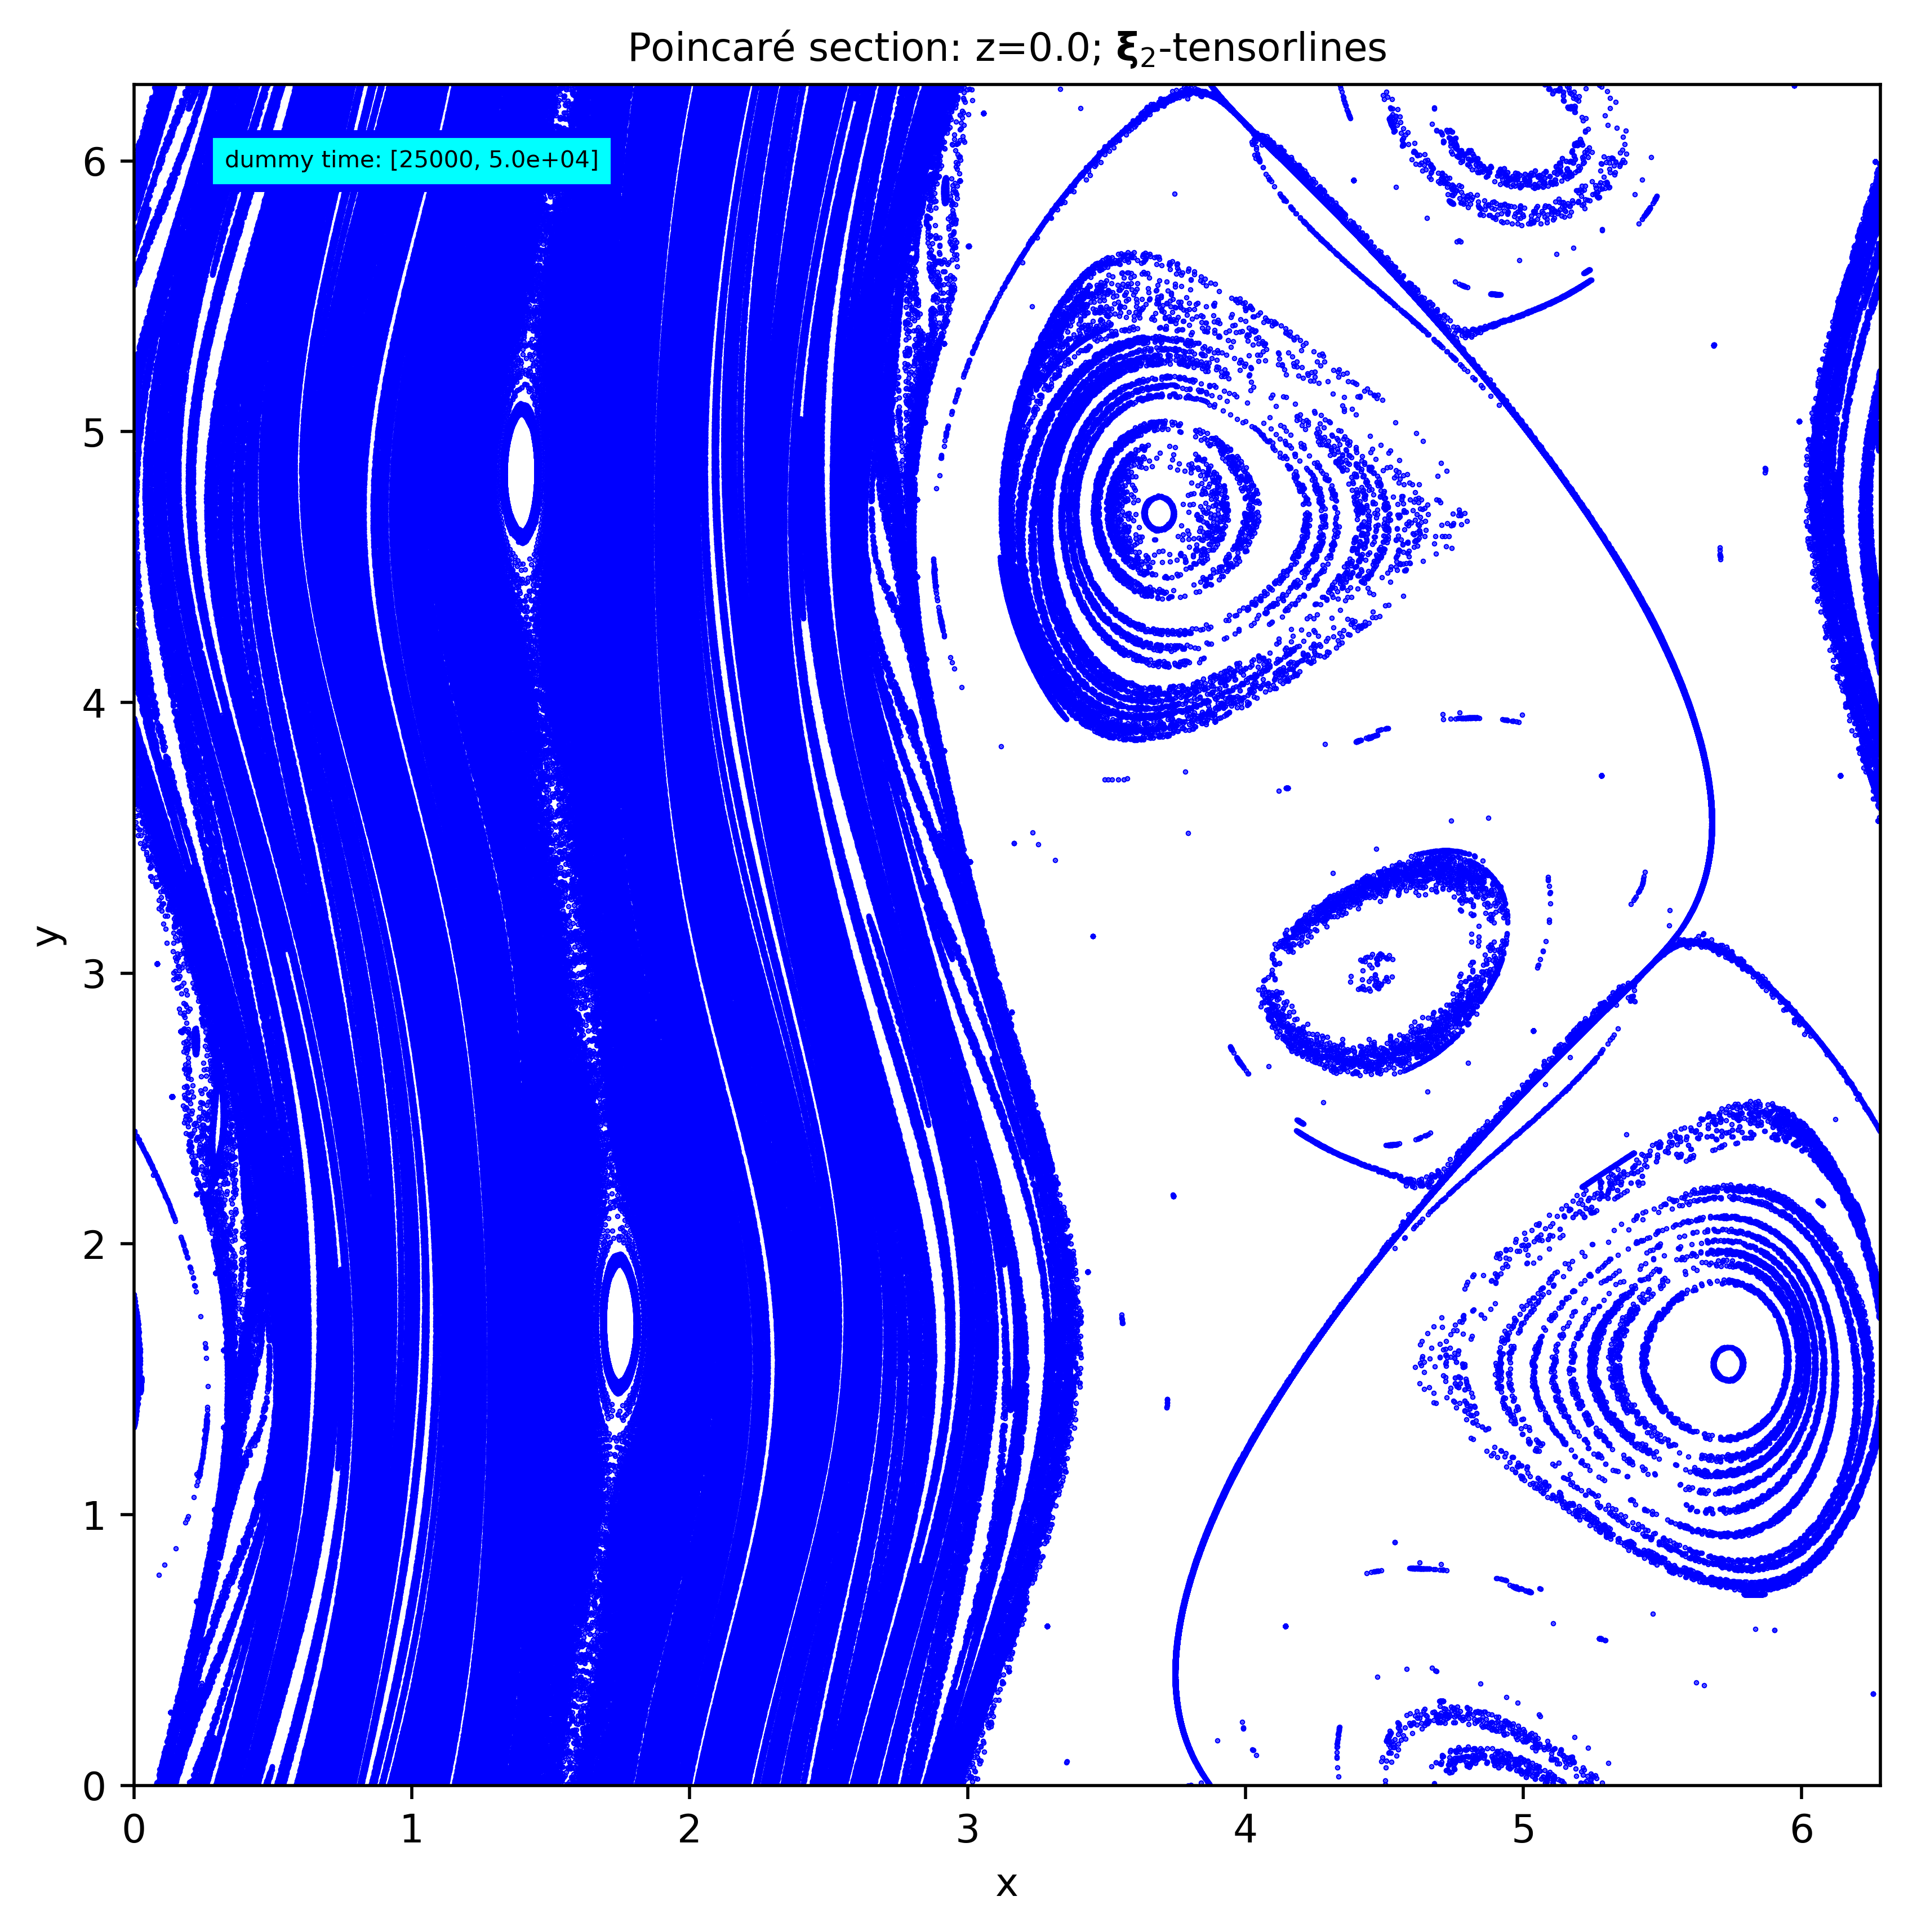

In [14]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize = (8, 8), dpi=500)
ax = plt.axes()

# Poincare Map
ax.scatter(x_intersec, y_intersec, c = "b", s = .15, marker = "o")

# Axis Label
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Axis limits
ax.set_xlim([0, 2*pi])
ax.set_ylim([0, 2*pi])

ax.text(
    1, 6, f'dummy time: [{int(0.5*s_dummy[-1]+1)}, {"{:.1e}".format(np.around(s_dummy[-1], 0))}]', ha="center", va="center", rotation=0, size=6,
    bbox=dict(fc="cyan", ec="b", lw=2))

# Title
ax.set_title(r'Poincaré section: z='f'{np.around(z0[0], 2)}; '+r'$ \mathbf{\xi}_{2}$'+'-tensorlines', fontsize = 10)

plt.savefig("PoincareMapABCsteadyanalytic_xi2.jpg", dpi = 500)

plt.show()

The $ \mathbf{\xi}_2 $ -Poincaré map reveals both vortical and hyperbolic flow features with much more clarity than the classic [Poincare Map](../../../AdvectiveBarriers/PoincareMap3D/Main/PoincareMapABCsteady_analytic.ipynb) computed from the same initial conditions.

# References
[1] Oettinger, D., & Haller, G. (2016). An autonomous dynamical system captures all LCSs in three-dimensional unsteady flows. Chaos: An Interdisciplinary Journal of Nonlinear Science, 26(10), 1031

[2] Notebook 5.8. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[3] [YouTube Tutorial](https://youtu.be/aNi5GQNavpM)